# $c_β$ Analysis

Run all cells to:
- Import clinical tables for TCGA and Lund cohorts
- Import and process TCGA gene expression data
- Import and process TCGA copy number data
- Add these data to TCGA clinical table, and save
- Generate figures, most relating to covariate analysis

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import EpiClockInvasiveBRCA.src.util as epi_util
consts = epi_util.consts

In [2]:
## Set up output directories for figures

figure_outdir = 'figures_revision'
clin_path_outdir = os.path.join(figure_outdir, 'clin_path')
cell_chars_outdir = os.path.join(figure_outdir, 'cell_chars')
supp_path_outdir = os.path.join(figure_outdir, 'supplementary')

os.makedirs(clin_path_outdir, exist_ok=True)
os.makedirs(cell_chars_outdir, exist_ok=True)
os.makedirs(supp_path_outdir, exist_ok=True)

## Prepare data

In [3]:
## Input data directories

TCGA_c_beta_dir = os.path.join(consts['repo_dir'], '3. Select fCpGs', 'outputs_revision')
Lund_clinical_dir = os.path.join(consts['official_indir'], 'Lund')
Lund_c_beta_dir = os.path.join(consts['repo_dir'], '4. Process Supplementary Data', 'outputs_revision', 'Lund')

### Clinical tables

In [4]:
## Import clinical data for both cohorts into data dictionary
## Import c_beta values into dataframes

clinical = {}

## Lund

clinical['Lund'] = pd.read_table(os.path.join(Lund_clinical_dir, 'Lund.clinical.revision.txt'), index_col=0, dtype={'grade':str})
clinical['Lund']['c_beta'] = pd.read_table(os.path.join(Lund_c_beta_dir, 'Lund.c_beta.txt'), index_col=0).squeeze("columns")

## TCGA

clinical['TCGA'] = pd.read_table(os.path.join(consts['TCGA_datadir'], 'TCGA.clinical.tsv'), index_col=0)
clinical['TCGA'] = clinical['TCGA'].set_index('bcr_patient_barcode')
c_beta_tcga = pd.read_table(os.path.join(TCGA_c_beta_dir, 'TCGA.c_beta.txt'), index_col=0, header=None).squeeze("columns")

# Change from sample IDs to patient IDs
c_beta_tcga.index = c_beta_tcga.index.map(epi_util.sampleToPatientID)

# Add c_beta as a column
clinical['TCGA']['c_beta'] = c_beta_tcga

# Eliminate sub-categories of T Stage and Stage
clinical['TCGA']['T Stage'] = clinical['TCGA']['ajcc_pathologic_t'].dropna().apply(lambda x:x[:2])
clinical['TCGA']['Stage'] = clinical['TCGA']['ajcc_pathologic_stage'].dropna().str.rstrip('ABC')

# Convert age from days to years
clinical['TCGA']['age'] = clinical['TCGA']['age_at_diagnosis'] / 365

# Add sample IDs to TCGA clinical table
patient_to_sample_IDs = pd.read_table(os.path.join(consts['TCGA_datadir'], 'patient_to_sample_IDs.txt'), index_col=0).squeeze('columns')
clinical['TCGA'] = clinical['TCGA'].merge(patient_to_sample_IDs, left_index=True, right_index=True, how='left')

In [5]:
(clinical['Lund']['spfPercent']*2/100).mean()

0.2069290322580645

### Import subtyping results

In [6]:
## Import pam50 subtype predictions from log2 norm TPM
## Merge subtype column with TCGA clinical table

TCGA_genefu_pam50_subtypes_log2_norm = pd.read_table(os.path.join(consts['repo_dir'], '5. Subtyping', 'TCGA.genefu.pam50.subtypes_log2.norm.txt'))
TCGA_genefu_pam50_subtypes_log2_norm.index = TCGA_genefu_pam50_subtypes_log2_norm['libName'].apply(lambda x:epi_util.sampleToPatientID(x.replace('.', '-')))
TCGA_genefu_pam50_subtypes_log2_norm = TCGA_genefu_pam50_subtypes_log2_norm.drop('libName', axis=1)
clinical['TCGA'] = clinical['TCGA'].merge(TCGA_genefu_pam50_subtypes_log2_norm['subtype.pam50'], left_index=True, right_index=True, how='left')

### Import IHC subtyping results

In [7]:
marker_state_dict = {
    'Equivocal':float('NaN'),
    'Indeterminate':float('NaN'),
    'Negative':'Negative', 'Positive':'Positive'}
for col in ['breast_carcinoma_estrogen_receptor_status', 'breast_carcinoma_progesterone_receptor_status',
           'lab_proc_her2_neu_immunohistochemistry_receptor_status']:
    clinical['TCGA'][col] = clinical['TCGA'][col].map(marker_state_dict)

clinical['TCGA']['HR+'] = (clinical['TCGA']['breast_carcinoma_estrogen_receptor_status'] == 'Positive') | (clinical['TCGA']['breast_carcinoma_progesterone_receptor_status'] == 'Positive')
clinical['TCGA']['HR-'] = (clinical['TCGA']['breast_carcinoma_estrogen_receptor_status'] == 'Negative') & (clinical['TCGA']['breast_carcinoma_progesterone_receptor_status'] == 'Negative')

clinical['TCGA']['LumA_type'] = clinical['TCGA']['HR+'] & (clinical['TCGA']['lab_proc_her2_neu_immunohistochemistry_receptor_status'] == 'Negative')
clinical['TCGA']['LumB_type'] = clinical['TCGA']['HR+'] & (clinical['TCGA']['lab_proc_her2_neu_immunohistochemistry_receptor_status'] == 'Positive')
clinical['TCGA']['Her2_type'] = (clinical['TCGA']['lab_proc_her2_neu_immunohistochemistry_receptor_status'] == 'Positive') & clinical['TCGA']['HR-']
clinical['TCGA']['Triple-Negative_type'] = clinical['TCGA']['HR-'] & (clinical['TCGA']['lab_proc_her2_neu_immunohistochemistry_receptor_status'] == 'Negative')

subtype_list = ['LumA_type', 'LumB_type', 'Her2_type', 'Triple-Negative_type']

for subtype in subtype_list:
    clinical['TCGA'][subtype] = clinical['TCGA'][subtype].map({True:subtype.split('_type')[0], False:''})

clinical['TCGA']['subtype.ihc'] = clinical['TCGA'][subtype_list].apply(lambda row:''.join(row), axis=1)
clinical['TCGA'].loc[clinical['TCGA']['subtype.ihc'] == '', 'subtype.ihc'] = None

clinical['TCGA'].drop(subtype_list, axis=1, inplace=True)

### Import mutation status data

In [8]:
mutations_TCGA = pd.read_table(os.path.join(consts['official_indir'], 'TCGA', 'TCGA.mutation.tsv'), low_memory=False)
mutations_TCGA['sampleID'] = mutations_TCGA['Tumor_Sample_Barcode'].map(epi_util.getSampleID)

In [9]:
ensmbl_IDs = {'BRCA1':'ENSG00000012048', 'BRCA2':'ENSG00000139618'}

# Restrict to BRCA1/2 rows
BRCA_mutations = mutations_TCGA.loc[mutations_TCGA['Gene'].isin([ensmbl_IDs['BRCA1'], ensmbl_IDs['BRCA2']])]
assert (BRCA_mutations['Mutation_Status'] == 'Somatic').all()
before = BRCA_mutations.shape[0]
print(BRCA_mutations.shape[0])

# Don't use silent mutations
display(BRCA_mutations.loc[BRCA_mutations['Variant_Classification'] == 'Silent'])
BRCA_mutations = BRCA_mutations.loc[BRCA_mutations['Variant_Classification'] != 'Silent']

after = BRCA_mutations.shape[0]
print(f'Removed {before - after} mutations')

display(BRCA_mutations['Variant_Classification'].value_counts())

# Add info to clinical table
clinical['TCGA']['BRCA1/2'] = clinical['TCGA']['sampleID'].isin(BRCA_mutations['sampleID']).map({True:'Mutation', False:'No mutation'})

25


,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,...,case_id,GDC_FILTER,COSMIC,hotspot,RNA_Support,RNA_depth,RNA_ref_count,RNA_alt_count,callers,sampleID
2268,BRCA1,672,WUGSC,GRCh38,chr17,43076523,43076523,+,Silent,SNP,...,d13fb44b-291b-4ea4-920c-142daa8d1989,NaN,NaN,N,Unknown,NaN,NaN,NaN,muse;mutect2;varscan2,TCGA-AC-A5EH-01A


Removed 1 mutations


Missense_Mutation    11
Frame_Shift_Del       6
Nonsense_Mutation     5
In_Frame_Del          1
Splice_Site           1
Name: Variant_Classification, dtype: int64

In [10]:
used_samples_mask = clinical['TCGA']['in_analysis_dataset'] & ~clinical['TCGA']['c_beta'].isna()
print(f'Analysis dataset: N = {used_samples_mask.sum()}')

Analysis dataset: N = 408


In [11]:
clinical['TCGA']['BRCA1/2'].loc[used_samples_mask].value_counts()

No mutation    385
Mutation        23
Name: BRCA1/2, dtype: int64

### RNA-seq

In [12]:
## Import RNA-seq TPM data

# Process TPM data table
markers_TPM_df = pd.read_table(
    os.path.join(consts['TCGA_datadir'], 'TCGA.rnaseq_tpm.tsv'),
    sep='\t')
markers_TPM_df = markers_TPM_df.set_index('gene_id')
markers_TPM_df = markers_TPM_df.rename(columns=epi_util.sampleToPatientID)

# Save gene_name series
# Can use it to map gene IDs to gene names
gene_name = markers_TPM_df.pop('gene_name')

# Only consider markers that are nonzero for at least one tumor
nonzero_values = (markers_TPM_df != 0).any(axis=1)
markers_TPM_df = markers_TPM_df.loc[nonzero_values]
gene_name = gene_name.loc[nonzero_values]

In [13]:
## NORMALIZATION STEP
## 1. Log transform TPM
## 2. Mean-center the values for each gene across all tumors

markers_log_transformed_df = np.log2(markers_TPM_df + 1)
markers_transformed_df = markers_log_transformed_df.apply(lambda col:col - markers_log_transformed_df.mean(axis=1), axis=0)
assert (markers_transformed_df.mean(axis=1) < 1e-5).all() # Sanity check

In [14]:
## Gene modules

# Import list of genes for each gene module from Fredlund et al.

gene_module_dict = {}
with open(os.path.join(consts['repo_dir'], 'data', 'Fredlund.gene.modules.txt'), 'r') as f:
    line_list = f.readlines()

for line in line_list:
    list_temp = line.rstrip().split('\t')
    gene_module_dict[list_temp[0]] = list_temp[1:]
    
# Add columns for the average expression of each gene module to clinical['TCGA']

for module in gene_module_dict.keys():
    markers = gene_module_dict[module]
    genes_used = gene_name.index[gene_name.isin(markers)]
    
    # Note if any genes are not present
    if genes_used.shape[0] != len(markers):
        print(f'{len(markers) - genes_used.shape[0]} genes not found from the {module} module')
    
    #
    selected_TPM = markers_transformed_df.loc[genes_used]
    avg_module_expression = selected_TPM.mean(axis=0)
    avg_module_expression.name = module
    clinical['TCGA'] = clinical['TCGA'].drop(module, axis=1, errors='ignore')
    clinical['TCGA'] = clinical['TCGA'].merge(avg_module_expression, left_index=True, right_index=True, how='left')

1 genes not found from the IR module


In [ ]:
## Include expression of certain genes in clinical table
## Genes specifically relevant for breast cancer

clinical['TCGA']['MKI67'] = markers_transformed_df.loc[gene_name.index[gene_name=='MKI67']].T
clinical['TCGA']['MCM2'] = markers_transformed_df.loc[gene_name.index[gene_name=='MCM2']].T

### Copy number analysis

In [16]:
## Import CNV table and transform data

CNV_df = pd.read_table(
    os.path.join(consts['TCGA_datadir'], 'TCGA.cnv.tsv'),
    sep='\t')

# Undo log transformation
CNV_df['CN'] = 2 * (2 ** CNV_df['Segment_Mean'])
all_samples = CNV_df['Sample'].unique()

In [17]:
## Iterate through samples and calculate CN losses and gains

# Thresholds for CN losses and gains
FGA_loss_threshold = 1.5
FGA_gain_threshold = 2.5

# Store FGA loss/gain for each sample
FGA_loss_list = []
FGA_gain_list = []
for samp in all_samples:

    # Select only rows corresponding to this sample
    sample_CNV_df = CNV_df.loc[CNV_df['Sample'] == samp]
    
    total_num_probes = sample_CNV_df['Num_Probes'].sum()
    
    # Sum of number of probes in regions that are beyond the loss and gain thresholds
    FGA_loss = sample_CNV_df.loc[sample_CNV_df['CN'] < FGA_loss_threshold, 'Num_Probes'].sum() / total_num_probes
    FGA_gain = sample_CNV_df.loc[sample_CNV_df['CN'] > FGA_gain_threshold, 'Num_Probes'].sum() / total_num_probes

    FGA_loss_list.append(FGA_loss)
    FGA_gain_list.append(FGA_gain)

# Create dataframe for calculated values
FGA_output = pd.DataFrame(index=all_samples, data={'FGA_loss':FGA_loss_list, 'FGA_gain':FGA_gain_list})
FGA_output['FGA'] = FGA_output['FGA_loss'] + FGA_output['FGA_gain']
FGA_output.index = FGA_output.index.to_series().apply(epi_util.sampleToPatientID)

# Add new columns to TCGA clinical table
clinical['TCGA'] = clinical['TCGA'].drop(['FGA_loss', 'FGA_gain', 'FGA'], axis=1, errors='ignore')
clinical['TCGA'] = clinical['TCGA'].merge(FGA_output, left_index=True, right_index=True, how='left')

## Make Figures

In [18]:
## Configure graph
sf = consts['sf']
figsize = np.array([7, 6])
sns.set(rc={"savefig.bbox":'tight', 'axes.linewidth':sf}, font_scale=1, style='ticks')

In [19]:
## Must set dataframe names for use of saveBoxPlotNew and saveCorrelationPlot

clinical['TCGA'].name = 'TCGA'
clinical['Lund'].name = 'Lund'

### 3 example tumors

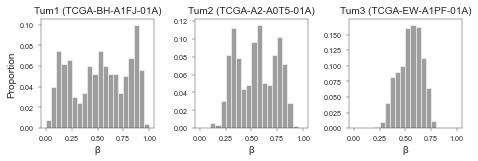

In [20]:
## Plot beta value distriubtions for 3 example tumors

beta_values_Clock = pd.read_table(os.path.join(consts['TCGA_datadir'], 'TCGA.methyl.Clock_revision.tsv'), index_col=0)

sample_list = {
    'Tum1':'TCGA-BH-A1FJ-01A',
    'Tum2':'TCGA-A2-A0T5-01A',
    'Tum3':'TCGA-EW-A1PF-01A'
}

epi_util.plotTumorWise(beta_values=beta_values_Clock, sample_list=[sample_list[tum] for tum in sample_list],
                     suptitle='', xlabel='β', title_formats=[tum + ' ({})' for tum in sample_list],
                     outfile=True, outdir=figure_outdir, outfile_name='example_tumors.pdf',
                     choose_random=False, color=consts['palette_jco'][2], bins=20,
                     figsize=figsize * [2.3, 0.8], text_fontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], opacity=consts['opacity'], sf=sf,
                     tight_layout_pad=0.2
             )

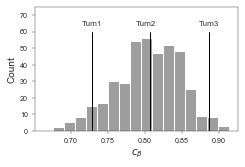

In [21]:
## Plot distribution of c_beta values across all tumors in TCGA set

# Values to plot
plot_data = clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset'], 'c_beta']

# Create plot
fig, ax = plt.subplots(1, 1, figsize=figsize * [1.3, 0.95] * sf)
sns.histplot(ax=ax, x=plot_data,
             color=consts['palette_jco'][2], alpha=consts['opacity'])

# Mark (with vertical lines) the c_beta values of three
#   example tumors from plot in the previous cell
line_color = 'black'
tumor_heights = [0.8, 0.8, 0.8]

x_0 = clinical['TCGA'].loc[epi_util.sampleToPatientID(sample_list['Tum1']), 'c_beta']
x_1 = clinical['TCGA'].loc[epi_util.sampleToPatientID(sample_list['Tum2']), 'c_beta']
x_2 = clinical['TCGA'].loc[epi_util.sampleToPatientID(sample_list['Tum3']), 'c_beta']

ax.axvline(x=x_0, ymax=tumor_heights[0], lw=2.5 * sf, color=line_color)
ax.axvline(x=x_1, ymax=tumor_heights[1], lw=2.5 * sf, color=line_color)
ax.axvline(x=x_2, ymax=tumor_heights[2], lw=2.5 * sf, color=line_color)

# Customize figure
ax.set_xlabel('$c_β$', fontsize=consts['labelfontsize'] * sf)
ax.set_ylabel('Count', fontsize=consts['labelfontsize'] * sf)
ax.tick_params(axis='both', labelsize=consts['ticksfontsize'] * sf, width=sf, length=8 * sf)
ax.set_ylim(top=75)

# Widen plot a little
xlim = ax.get_xlim()
width = xlim[1] - xlim[0]
ax.set_xlim(left = xlim[0] - width/20)

# Annotate the vertical lines with text for all 3 tumors
y_height = ax.get_ylim()[1]

ax.text(x_0, (tumor_heights[0]+0.05)*y_height,
        'Tum1', color=line_color,
        ha="center", fontfamily='sans-serif', fontsize=0.8 * consts['labelfontsize'] * sf, alpha=consts['opacity']
       )
ax.text(x_1-0.005, (tumor_heights[1]+0.05)*y_height,
        'Tum2', color=line_color,
        ha="center", fontfamily='sans-serif', fontsize=0.8 * consts['labelfontsize'] * sf, alpha=consts['opacity']
       )
ax.text(x_2, (tumor_heights[2]+0.05)*y_height,
        'Tum3', color=line_color,
        ha="center", fontfamily='sans-serif', fontsize=0.8 * consts['labelfontsize'] * sf, alpha=consts['opacity']
       )

# Save figure
fig.savefig(os.path.join(figure_outdir, 'c_beta_distribution.pdf'), format='pdf', pad_inches=0.1)

### Calculate statistics

In [22]:
# c_beta value in ductal vs lobular tumors
ductal_c_betas = clinical['TCGA'].loc[clinical['TCGA']['primary_diagnosis'] == 'Infiltrating duct carcinoma, NOS', 'c_beta'].dropna()
lobular_c_betas = clinical['TCGA'].loc[clinical['TCGA']['primary_diagnosis'] == 'Lobular carcinoma, NOS', 'c_beta'].dropna()
pvalue = epi_util.wilcoxonRankSums(ductal_c_betas, lobular_c_betas).pvalue

print(f'Median c_beta of ductal TCGA tumors: {np.median(ductal_c_betas):.2f}')
print(f'Median c_beta of lobular TCGA tumors: {np.median(lobular_c_betas):.2f}')
print(f'Wilcoxon rank sum test: P={pvalue:.0e}')

Median c_beta of ductal TCGA tumors: 0.81
Median c_beta of lobular TCGA tumors: 0.85
Wilcoxon rank sum test: P=8e-15


In [23]:
# c_beta value in ductal luminal A vs lobular tumors
ductal_lumA_c_betas = clinical['TCGA'].loc[(clinical['TCGA']['primary_diagnosis'] == 'Infiltrating duct carcinoma, NOS') & (clinical['TCGA']['subtype.pam50'] == 'LumA'), 'c_beta'].dropna()
lobular_c_betas = clinical['TCGA'].loc[clinical['TCGA']['primary_diagnosis'] == 'Lobular carcinoma, NOS', 'c_beta'].dropna()
pvalue = epi_util.wilcoxonRankSums(ductal_lumA_c_betas, lobular_c_betas).pvalue

print(f'Median c_beta of ductal Luminal A TCGA tumors: {np.median(ductal_lumA_c_betas):.3f}')
print(f'Median c_beta of lobular TCGA tumors: {np.median(lobular_c_betas):.3f}')
print(f'Wilcoxon rank sum test: P={pvalue:.0e}')

Median c_beta of ductal Luminal A TCGA tumors: 0.824
Median c_beta of lobular TCGA tumors: 0.846
Wilcoxon rank sum test: P=3e-04


In [24]:
# CPE value in ductal vs lobular tumors
ductal_CPE = clinical['TCGA'].loc[clinical['TCGA']['primary_diagnosis'] == 'Infiltrating duct carcinoma, NOS', 'CPE'].dropna()
lobular_CPE = clinical['TCGA'].loc[clinical['TCGA']['primary_diagnosis'] == 'Lobular carcinoma, NOS', 'CPE'].dropna()
pvalue = epi_util.wilcoxonRankSums(ductal_CPE, lobular_CPE).pvalue

print(f'Median CPE of ductal TCGA tumors: {np.median(ductal_CPE):.3f}')
print(f'Median CPE of lobular TCGA tumors: {np.median(lobular_CPE):.3f}')
print(f'Wilcoxon rank sum test: P={pvalue:.0e}')

Median CPE of ductal TCGA tumors: 0.786
Median CPE of lobular TCGA tumors: 0.747
Wilcoxon rank sum test: P=1e-03


In [25]:
clinical['Lund']['in_analysis_dataset'].sum()

98

In [26]:
def printCorr(dataset, var_x, var_y='c_beta'):
    """
    Function used to print the Pearson correlation R and p-value between c_beta and some other variable
    Specifying the cohort
    """
    ductal_samples = clinical[dataset].index[clinical[dataset]['in_analysis_dataset']].values
    res = epi_util.getCorrelation(clinical[dataset], var_x=var_x, var_y=var_y, use_samples=ductal_samples)
    pvalue_formatted = f'{res.pvalue:.0e}' if res.pvalue < 0.01 else f'{res.pvalue:.2f}'
    print(f'{dataset}, {var_x}: R={res.rvalue:.2f}, P={pvalue_formatted}')

## Get correlation results for several variables
printCorr('TCGA', 'age')
printCorr('Lund', 'age')
printCorr('Lund', 'size')
printCorr('TCGA', 'MKI67')
printCorr('TCGA', 'MCM2')
printCorr('TCGA', 'Mitotic Checkpoint')
printCorr('Lund', 'Mitotic Checkpoint')
printCorr('Lund', 'spfPercent')
printCorr('TCGA', 'FGA')
printCorr('Lund', 'FGA')
printCorr('TCGA', 'CPE')
printCorr('Lund', 'LUMP')

TCGA, age: R=-0.18, P=4e-04
Lund, age: R=-0.10, P=0.35
Lund, size: R=-0.22, P=0.03
TCGA, MKI67: R=-0.17, P=4e-04
TCGA, MCM2: R=-0.18, P=3e-04
TCGA, Mitotic Checkpoint: R=-0.23, P=4e-06
Lund, Mitotic Checkpoint: R=-0.42, P=2e-05
Lund, spfPercent: R=-0.41, P=7e-05
TCGA, FGA: R=-0.58, P=4e-38
Lund, FGA: R=-0.48, P=9e-07
TCGA, CPE: R=-0.70, P=1e-61
Lund, LUMP: R=-0.42, P=2e-05


In [27]:
clinical['Lund']['in_CpG_dataset'].sum()

146

In [28]:
clinical['Lund']['c_beta']

GSM1941862         NaN
GSM1941863         NaN
GSM1941864         NaN
GSM1941865         NaN
GSM1941867         NaN
                ...   
GSM1942045    0.807018
GSM1942046         NaN
GSM1942047         NaN
GSM1942048    0.832581
GSM1942049    0.775189
Name: c_beta, Length: 184, dtype: float64

### Main text box and scatter plots

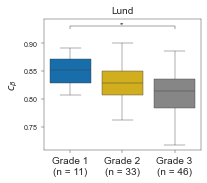

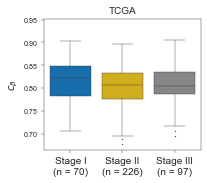

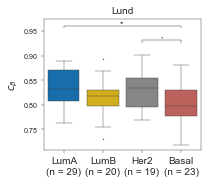

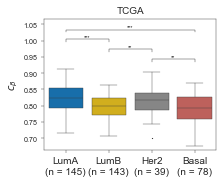

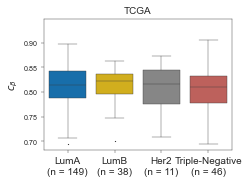

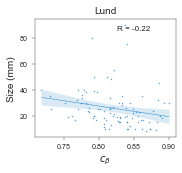

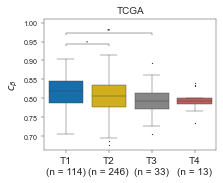

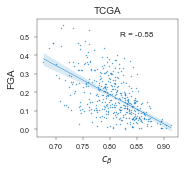

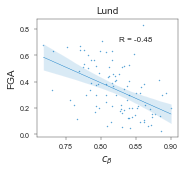

In [29]:
## Figure 4
## Create and save plots

# Box plots -- showing c_beta in TCGA/Lund cohort stratifying by some variable
# Scatter plots -- showing c_beta in TCGA/Lund cohort vs some variable

epi_util.saveBoxPlotNew(clinical['Lund'], 'grade', restrict=True,
                   var_y='c_beta',
                   outdir=clin_path_outdir, title=True, use_groups=['Grade 1', 'Grade 2', 'Grade 3'],
                   palette=consts['palette_jco'], plot_ymax_mult=0.29,
                   figsize=figsize, labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=sf, linewidth=consts['linewidth'], fliersize=consts['fliersize'])

epi_util.saveBoxPlotNew(clinical['TCGA'], 'Stage', restrict=True,
                   var_y='c_beta',
                   outdir=clin_path_outdir, title=True, use_groups = ['Stage I', 'Stage II', 'Stage III'],
                   palette=consts['palette_jco'],
                   figsize=figsize, labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=sf, linewidth=consts['linewidth'], fliersize=consts['fliersize'])

epi_util.saveBoxPlotNew(clinical['Lund'], 'genefu.pam50.subtype', restrict=True,
                   var_y='c_beta',
                   outdir=clin_path_outdir, title=True, use_groups = ['LumA', 'LumB', 'Her2', 'Basal'],
                   palette=consts['palette_jco'],
                   figsize=figsize, labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=sf, linewidth=consts['linewidth'], fliersize=consts['fliersize'])

epi_util.saveBoxPlotNew(clinical['TCGA'], 'subtype.pam50', restrict=True,
                   var_y='c_beta',
                   outdir=clin_path_outdir, title=True, use_groups = ['LumA', 'LumB', 'Her2', 'Basal'],
                   palette=consts['palette_jco'], plot_ymax_mult=0.2,
                   figsize=figsize * [1.1, 1], labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=sf, linewidth=consts['linewidth'], fliersize=consts['fliersize'])

epi_util.saveBoxPlotNew(clinical['TCGA'], 'subtype.ihc', restrict=True,
                   var_y='c_beta',
                   outdir=clin_path_outdir, title=True, use_groups = ['LumA', 'LumB', 'Her2', 'Triple-Negative'],
                   palette=consts['palette_jco'],
                   figsize=figsize * [1.2, 1], labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=sf, linewidth=consts['linewidth'], fliersize=consts['fliersize'])

epi_util.saveCorrelationPlot(clinical['Lund'], var_y='size', restrict=True,
                           var_x='c_beta',
                           outdir=clin_path_outdir, ylabel='Size (mm)',
                           text_x=0.85, text_y=85,
                           figsize=figsize * 0.9, labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=sf, s=1,
                           color=consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

epi_util.saveBoxPlotNew(clinical['TCGA'], 'T Stage', restrict=True,
                   var_y='c_beta',
                   outdir=clin_path_outdir, title=True, use_groups = ['T1', 'T2', 'T3', 'T4'],
                   palette=consts['palette_jco'],
                   figsize=figsize * [1.1, 1], labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=sf, linewidth=consts['linewidth'], fliersize=consts['fliersize'])

epi_util.saveCorrelationPlot(clinical['TCGA'], var_y='FGA', restrict=True,
                           var_x='c_beta',
                           outdir=cell_chars_outdir, ylabel='FGA',
                           text_x=0.85, text_y=0.5,
                           figsize=figsize * 0.9, labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=sf, s=1,
                           color=consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

epi_util.saveCorrelationPlot(clinical['Lund'], var_y='FGA', restrict=True,
                           var_x='c_beta',
                           outdir=cell_chars_outdir, ylabel='FGA',
                           text_x=0.85, text_y=0.7,
                           figsize=figsize * 0.9, labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=sf, s=1,
                           color=consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

#### BRCA1/2 Mutation

In [30]:
display(epi_util.getWilcoxonPvalueTable(clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset']], 'BRCA1/2', 'c_beta'))

clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset']].groupby('BRCA1/2')['c_beta'].median()

,No mutation,Mutation
No mutation,NaN,0.29484
Mutation,NaN,NaN


BRCA1/2
Mutation       0.812109
No mutation    0.806735
Name: c_beta, dtype: float64

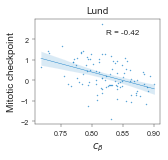

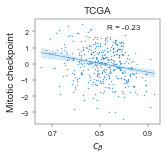

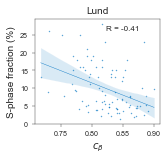

In [31]:
## Figure 5 scatterplots -- showing c_beta in TCGA/Lund cohort vs some variable
## Create and save plots

epi_util.saveCorrelationPlot(clinical['Lund'], var_y='Mitotic Checkpoint', restrict=True,
                           var_x='c_beta',
                           outdir=cell_chars_outdir,
                           text_x=0.85, text_y=2.2,
                           figsize=figsize * 0.8, labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=sf, s=1,
                           color=consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

epi_util.saveCorrelationPlot(clinical['TCGA'], var_y='Mitotic Checkpoint', restrict=True,
                           var_x='c_beta',
                           outdir=cell_chars_outdir,
                           text_x=0.85, text_y=2.1,
                           figsize=figsize * 0.8, labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=sf, s=1,
                           color=consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

epi_util.saveCorrelationPlot(clinical['Lund'], var_y='spfPercent', restrict=True,
                           var_x='c_beta',
                           ylabel='S-phase fraction (%)',
                           outdir=cell_chars_outdir,
                           text_x=0.85, text_y=26,
                           figsize=figsize * 0.8, labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=sf, s=1,
                           color=consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

### Correlation of all genes

In [32]:
# List of genes to search
gene_list = markers_transformed_df.index.values 

# List of samples to use
use_samples = clinical['TCGA'].index[clinical['TCGA']['in_analysis_dataset']] 

c_beta_use_samples = clinical['TCGA'].loc[use_samples, 'c_beta']
markers_transformed_df_use_samples = markers_transformed_df[use_samples]

# Calculate Pearson R between the expression of each gene and c_beta
rvalue_list = []
for i in range(len(gene_list)):
    if i % 5000 == 0:
        print(i)
    
    res = epi_util.pearsonCorrelation(c_beta_use_samples, markers_transformed_df_use_samples.loc[gene_list[i]])
    rvalue_list.append(res.rvalue)

# Save r-values in a Series
rvalue_ser = pd.Series(index=gene_list, data=rvalue_list)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000


19259 protein coding genes considered


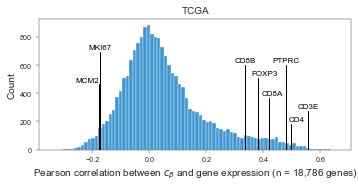

In [33]:
## Plot distribution of r-values
## Mark location of several genes of interest with vertical lines

# List of protein-coding genes
genenames_proteincoding = pd.read_table(os.path.join(consts['repo_dir'], 'data', 'genenames.proteincoding.txt'),
                                       low_memory=False, usecols=['symbol']).squeeze('columns').values
print(f'{genenames_proteincoding.shape[0]} protein coding genes considered')

# Only plot r-values of known protein-coding genes
plot_data = rvalue_ser[gene_name.isin(genenames_proteincoding)]

# Create plot
fig, ax = plt.subplots(1, 1, figsize=figsize * [2, 1] * sf)
sns.histplot(ax=ax, x=plot_data,
             color=consts['palette_jco'][0])


# Manually set height of lines and horizontal offset of text from the lines (if necessary)
gene_heights = {
    'MKI67': 0.75,
    'MCM2': 0.5,
    'CD3E': 0.3,
    'CD4': 0.2,
    'CD8A': 0.4,
    'CD8B': 0.65,
    'FOXP3': 0.55,
    'PTPRC': 0.65
}
horiz_offset = {
    'MCM2':-0.04,
    'CD8A':0.01,
    'CD4':0.02,
    'FOXP3':0.02
}

# Plot vertical lines
y_height = ax.get_ylim()[1]
for gene in gene_heights:
    corr = rvalue_ser.loc[gene_name.index[gene_name == gene]].values
    assert len(corr) == 1     # Sanity check
    
    # 
    x_pos = corr[0]
    if gene in horiz_offset:
        x_pos += horiz_offset[gene]
    ax.axvline(x=corr[0], ymin=0, ymax=gene_heights[gene], color='black', lw=2.5 * sf)
    ax.text(x_pos, (gene_heights[gene] + 0.02)*y_height, gene,
            ha="center", fontfamily='sans-serif',
            fontsize=consts['labelfontsize'] * 0.8 * sf, color='black')

# Customize figure
ax.set_ylabel('Count', fontsize=consts['labelfontsize'] * sf)
ax.set_xlabel(f'Pearson correlation between $c_β$ and gene expression (n = {len(plot_data):,} genes)', fontsize=consts['labelfontsize'] * sf)
ax.set_title(f'TCGA', fontsize=consts['labelfontsize'] * sf)
ax.tick_params(axis='both', labelsize=consts['ticksfontsize'] * sf, width=sf, length=8 * sf)

# Save figure
fig.savefig(os.path.join(cell_chars_outdir, 'all_gene_correlations.pdf'), format='pdf', pad_inches=0.1)

In [34]:
## Get correlation results for several genes
immune_markers = ['CD3D', 'CD3E', 'CD3G', 'CD4', 'CD68', 'CD8A', 'CD8B', 'FOXP3', 'MS4A1', 'NCAM1', 'PTPRC']
for im in immune_markers:
    clinical['TCGA'][im] = markers_transformed_df.loc[gene_name.index[gene_name==im]].T
    printCorr('TCGA', im)

TCGA, CD3D: R=0.54, P=7e-33
TCGA, CD3E: R=0.56, P=1e-34
TCGA, CD3G: R=0.51, P=8e-29
TCGA, CD4: R=0.50, P=1e-26
TCGA, CD68: R=0.09, P=0.06
TCGA, CD8A: R=0.42, P=8e-19
TCGA, CD8B: R=0.34, P=3e-12
TCGA, FOXP3: R=0.38, P=1e-15
TCGA, MS4A1: R=0.45, P=3e-21
TCGA, NCAM1: R=0.13, P=0.01
TCGA, PTPRC: R=0.48, P=8e-25


### $c_β^a$ analysis (adjusted for purity)

In [35]:
# Import purity adjusted c_beta values
c_beta_adj1_tcga = pd.read_table(os.path.join(consts['TCGA_datadir'], 'c_beta_adj1_revision.tsv')).squeeze('columns')
c_beta_adj1_tcga.index = c_beta_adj1_tcga.index.map(epi_util.sampleToPatientID)
clinical['TCGA']['c_beta_adj1'] = c_beta_adj1_tcga

# Have to reset the name of the dataframe
clinical['TCGA'].name = 'TCGA'

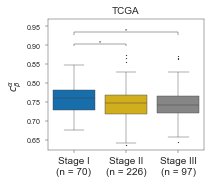

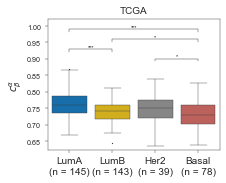

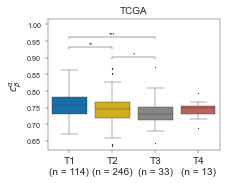

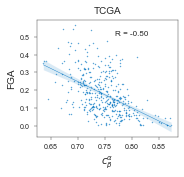

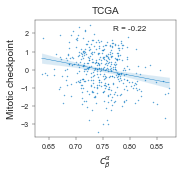

In [36]:
## Supplementary figure
## Create and save plots

# Box plots -- showing c_beta^a in TCGA cohort stratifying by some variable
# Scatter plots -- showing c_beta^a in TCGA cohort vs some variable

epi_util.saveBoxPlotNew(clinical['TCGA'], 'Stage', restrict=True,
                   var_y='c_beta_adj1',
                   outdir=supp_path_outdir, title=True, use_groups = ['Stage I', 'Stage II', 'Stage III'],
                   palette=consts['palette_jco'],
                   figsize=figsize, labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=sf, linewidth=consts['linewidth'], fliersize=consts['fliersize'])

epi_util.saveBoxPlotNew(clinical['TCGA'], 'subtype.pam50', restrict=True,
                   var_y='c_beta_adj1',
                   outdir=supp_path_outdir, title=True, use_groups = ['LumA', 'LumB', 'Her2', 'Basal'],
                   palette=consts['palette_jco'], plot_ymax_mult=0.2,
                   figsize=figsize * [1.1, 1], labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=sf, linewidth=consts['linewidth'], fliersize=consts['fliersize'])

epi_util.saveBoxPlotNew(clinical['TCGA'], 'T Stage', restrict=True,
                   var_y='c_beta_adj1',
                   outdir=supp_path_outdir, title=True, use_groups = ['T1', 'T2', 'T3', 'T4'],
                   palette=consts['palette_jco'],
                   figsize=figsize * [1.1, 1], labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=sf, linewidth=consts['linewidth'], fliersize=consts['fliersize'])


epi_util.saveCorrelationPlot(clinical['TCGA'], var_y='FGA', restrict=True,
                           var_x='c_beta_adj1',
                           outdir=supp_path_outdir, ylabel='FGA',
                           text_x=0.8, text_y=0.5,
                           figsize=figsize * 0.9, labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=sf, s=1,
                           color=consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

epi_util.saveCorrelationPlot(clinical['TCGA'], var_y='Mitotic Checkpoint', restrict=True,
                           var_x='c_beta_adj1',
                           outdir=supp_path_outdir,
                           text_x=0.8, text_y=2.1,
                           figsize=figsize * 0.9, labelfontsize=consts['labelfontsize'], ticksfontsize=consts['ticksfontsize'], sf=sf, s=1,
                           color=consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

In [37]:
## Get correlation results for several variables
printCorr('TCGA', 'age', 'c_beta_adj1')
printCorr('TCGA', 'MKI67', 'c_beta_adj1')
printCorr('TCGA', 'MCM2', 'c_beta_adj1')
printCorr('TCGA', 'Mitotic Checkpoint', 'c_beta_adj1')
printCorr('TCGA', 'FGA', 'c_beta_adj1')
printCorr('TCGA', 'CPE', 'c_beta_adj1')

TCGA, age: R=-0.18, P=3e-04
TCGA, MKI67: R=-0.18, P=2e-04
TCGA, MCM2: R=-0.16, P=1e-03
TCGA, Mitotic Checkpoint: R=-0.22, P=9e-06
TCGA, FGA: R=-0.50, P=1e-26
TCGA, CPE: R=-0.25, P=3e-07


In [38]:
for im in immune_markers:
    clinical['TCGA'][im] = markers_transformed_df.loc[gene_name.index[gene_name==im]].T
    printCorr('TCGA', im, 'c_beta_adj1')

TCGA, CD3D: R=0.34, P=3e-12
TCGA, CD3E: R=0.36, P=1e-13
TCGA, CD3G: R=0.33, P=1e-11
TCGA, CD4: R=0.25, P=2e-07
TCGA, CD68: R=-0.01, P=0.88
TCGA, CD8A: R=0.29, P=4e-09
TCGA, CD8B: R=0.22, P=7e-06
TCGA, FOXP3: R=0.19, P=1e-04
TCGA, MS4A1: R=0.36, P=4e-14
TCGA, NCAM1: R=0.05, P=0.34
TCGA, PTPRC: R=0.28, P=1e-08


### Save annotated clinical file for TCGA cohort

In [40]:
## Save modified TCGA clinical table

# Outfile path
clinical_annotated_filepath = os.path.join(consts['TCGA_datadir'], 'TCGA.clinical.annotated_revision.tsv')

# Save, don't overwrite existing file
if os.path.exists(clinical_annotated_filepath):
    existing_table = pd.read_table(clinical_annotated_filepath, index_col=0)
    assert (existing_table.round(5).fillna(0) == clinical['TCGA'].round(5).fillna(0)).all(axis=None, skipna=True)
    print('Current output matches existing file.')
else:
    clinical['TCGA'].to_csv(clinical_annotated_filepath, sep='\t')

Current output matches existing file.
